In [1]:
import os
import re
from collections import defaultdict
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Generate tables

In [3]:
EXPERIMENTS_DIR = 'cluster/experiments'
FIG_DIR = 'figures'
DATASETS = ['mnist', 'inat']
PLOT_ORDER = ["softmax", "sigsoftmax", "plif", "mos", "moss"]

In [4]:
def _get_score_files(dataset: str) -> list[str]:
    return [f for f in os.listdir(f'{EXPERIMENTS_DIR}/{dataset}')
            if f.endswith('scores')]


def _find_metrics(lines: list[str], start_text, dtype) -> list:
    str_metrics = [line.replace(f'{start_text}: ', '') for line in lines
                   if line.startswith(start_text)]
    return [[dtype(value) for value in s.split(',')] for s in str_metrics]


def _pick_argmaxes_test_accuracy(train_losses: list[list[float]],
    test_losses: list[list[float]], train_accuracies: list[list[float]],
    test_accuracies: list[list[float]], ranks: list[list[int]]) -> None:
    """Replace scores for a seed with a single value at the best
    test accuracy.
    """
    for seed in range(len(test_accuracies)):
        argmax = np.argmax(test_accuracies[seed])
        train_losses[seed] = train_losses[seed][argmax]
        test_losses[seed] = test_losses[seed][argmax]
        train_accuracies[seed] = train_accuracies[seed][argmax]
        test_accuracies[seed] = test_accuracies[seed][argmax]
        ranks[seed] = ranks[seed][argmax]


def _extract_list_scores(scores: defaultdict, dataset: str) -> None:
    activations = scores.keys()
    ds = scores[list(activations)[0]].keys()
    for activation in activations:
        for d in ds:
            with open(f'{EXPERIMENTS_DIR}/{dataset}/'
                      f'{scores[activation][d]["file"]}', 'r') as f:
                lines = f.read().splitlines()
            train_losses = _find_metrics(lines, 'Train loss', float)
            test_losses = _find_metrics(lines, 'Test loss', float)
            train_accuracies = _find_metrics(lines, 'Train accuracy', float)
            test_accuracies = _find_metrics(lines, 'Test accuracy', float)
            ranks = _find_metrics(lines, 'Rank', int)
            _pick_argmaxes_test_accuracy(train_losses, test_losses, train_accuracies,
                                         test_accuracies, ranks)
            scores[activation][d]['train_loss'] = train_losses
            scores[activation][d]['test_loss'] = test_losses
            scores[activation][d]['train_accuracy'] = train_accuracies
            scores[activation][d]['test_accuracy'] = test_accuracies
            scores[activation][d]['rank'] = ranks
    

def build_scores_dict(dataset: str) -> dict:
    """Builds dictionary with the following structure:
    activation: str
    - d: int
    - - file: str
    - - train_loss: list[float]
    - - test_loss: list[float]
    - - train_accuracy: list[float]
    - - test_accuracy: list[float]
    - - rank: list[int]
    """
    scores = defaultdict(lambda: defaultdict(lambda: defaultdict()))
    for file in _get_score_files(dataset):
        file_subnames = file.split('_')
        activation = file_subnames[1]
        d = int(file_subnames[-2].replace('d', '').replace('m', ''))
        scores[activation][d]['file'] = file
    _extract_list_scores(scores, dataset)
    return scores

def _get_statistic(values: list, best: bool) -> str:
    statistic = f"${round(np.mean(values), 2)} "\
                f"\pm {round(np.std(values), 2)}$"
    if best:
        statistic = "$\mathbf{" + statistic[1:-1] + "}$"
    return statistic

def print_table(scores: dict, cols: list[str]):
    activations = ['softmax', 'sigsoftmax', 'plif', 'mos', 'moss']
    ds = list(scores[list(activations)[0]].keys())
    ds.sort(reverse=True)
    readable_cols = [col.replace('_', ' ') for col in cols]
    df = pd.DataFrame(columns=['d', 'model'] + readable_cols)

    for d in ds:
        for activation in activations:
            row = dict()
            for col in cols:
                best = False
                operator = min if "loss" in col else max
                if (np.mean(scores[activation][d][col]) == 
                    operator(np.mean(scores[a][d][col]) for a in activations)):
                    best = True
                row[col.replace('_', ' ')] = _get_statistic(
                    scores[activation][d][col], best)
            row['model'] = activation
            row['d'] = d
            df = df.append(row, ignore_index=True)

    print(df.to_latex(escape=False, index=False, column_format='|r|l|l|l|l|l|'))

In [5]:
for dataset in DATASETS:
    scores = build_scores_dict(dataset)
    with open(f'{dataset}_scores.json', 'w') as f:
        json.dump(scores, f)
    print('PRINTING TABLE FOR ' + dataset + '\n')
    print_table(scores, ['train_loss', 'test_loss', 'train_accuracy', 'test_accuracy'])
    print('\n\n')

PRINTING TABLE FOR mnist

\begin{tabular}{|r|l|l|l|l|l|}
\toprule
  d &      model &               train loss &                test loss &             train accuracy &              test accuracy \\
\midrule
128 &    softmax &            $0.0 \pm 0.0$ &           $0.03 \pm 0.0$ &           $99.96 \pm 0.07$ &           $99.37 \pm 0.05$ \\
128 & sigsoftmax &   $\mathbf{0.0 \pm 0.0}$ &           $0.03 \pm 0.0$ &  $\mathbf{99.96 \pm 0.05}$ &           $99.37 \pm 0.06$ \\
128 &       plif &            $0.0 \pm 0.0$ &           $0.03 \pm 0.0$ &  $\mathbf{99.96 \pm 0.05}$ &           $99.38 \pm 0.04$ \\
128 &        mos &            $0.0 \pm 0.0$ &           $0.03 \pm 0.0$ &           $99.86 \pm 0.05$ &           $99.44 \pm 0.05$ \\
128 &       moss &            $0.0 \pm 0.0$ &  $\mathbf{0.03 \pm 0.0}$ &           $99.93 \pm 0.06$ &  $\mathbf{99.48 \pm 0.04}$ \\
  9 &    softmax &            $0.0 \pm 0.0$ &          $0.09 \pm 0.04$ &           $99.91 \pm 0.09$ &           $98.53 \pm 0.71$ \\
 

## Unlucky seeds

In [6]:
scores = build_scores_dict("mnist")

In [7]:
ds = scores['softmax'].keys()
activations = scores.keys()
unlucky_seeds_df = pd.DataFrame(columns=['model', 'd', 'unlucky'])
only_lucky_df = pd.DataFrame(columns=['model', 'd', 'accuracy'])
for activation in activations:
    for d in ds:
        unlucky_seeds_df = unlucky_seeds_df.append(
            {'d': d, 'model': activation,
             'unlucky': len([x for x in scores[activation][d]['test_accuracy']
                             if x <13])}, ignore_index=True)
        for accuracy in scores[activation][d]['test_accuracy']:
            if accuracy >= 13:     
                only_lucky_df = only_lucky_df.append(
                    {'d': d, 'model': activation,
                     'accuracy': accuracy}, ignore_index=True)
unlucky_seeds_df.sort_values('unlucky', ascending=False).head()

,model,d,unlucky
29,plif,1,5
49,sigsoftmax,1,4
19,softmax,1,4
43,sigsoftmax,2,4
48,sigsoftmax,3,2


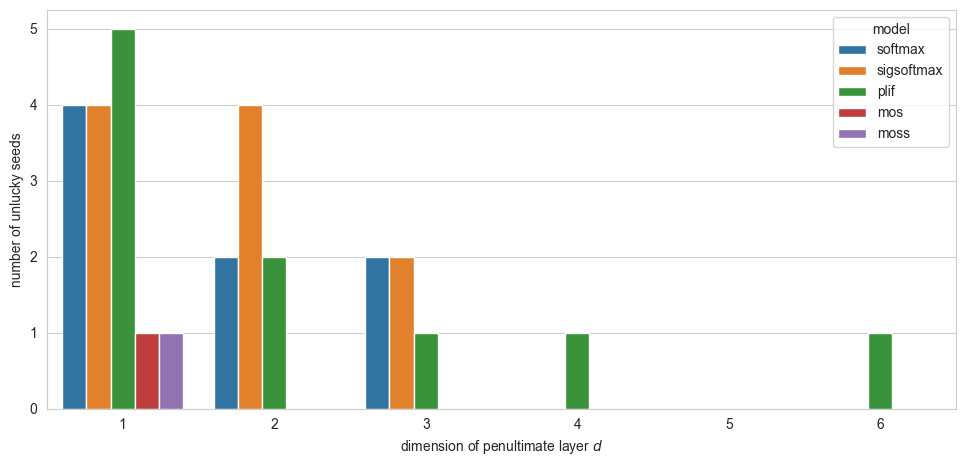

In [8]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=unlucky_seeds_df[unlucky_seeds_df['d'] <= 6],
            x="d", y="unlucky", hue="model", ax=ax,
            hue_order=PLOT_ORDER)
sns.set(font_scale=1.5)
ax.set(xlabel='dimension of penultimate layer $d$', ylabel='number of unlucky seeds')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/unlucky_seeds.pdf')

In [9]:
only_lucky_df.head()

,model,d,accuracy
0,mos,4,96.9
1,mos,4,98.0
2,mos,4,98.3
3,mos,4,98.1
4,mos,4,97.9


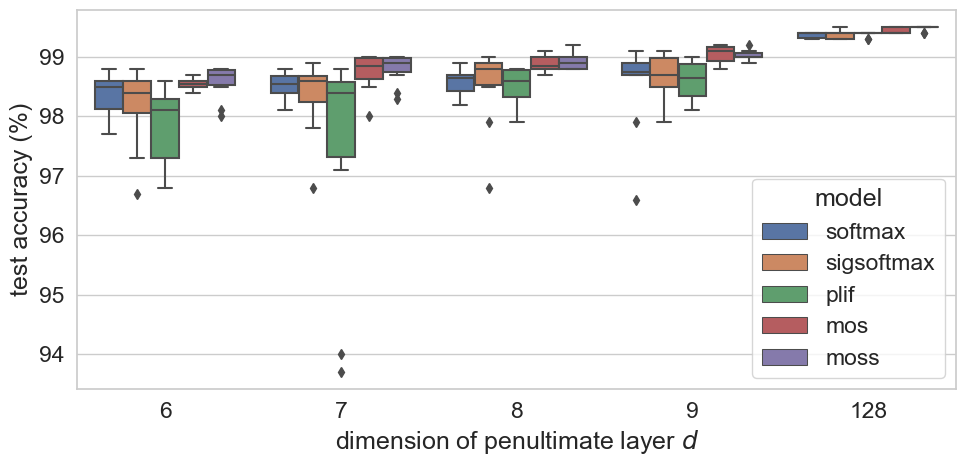

In [10]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=only_lucky_df[only_lucky_df['d'] >= 6],
            x="d", y="accuracy", hue="model", ax=ax,
            hue_order=PLOT_ORDER)
sns.set(font_scale=1.5)
ax.set(xlabel='dimension of penultimate layer $d$', ylabel='test accuracy (%)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/mnist_accuracy_high_d.pdf')

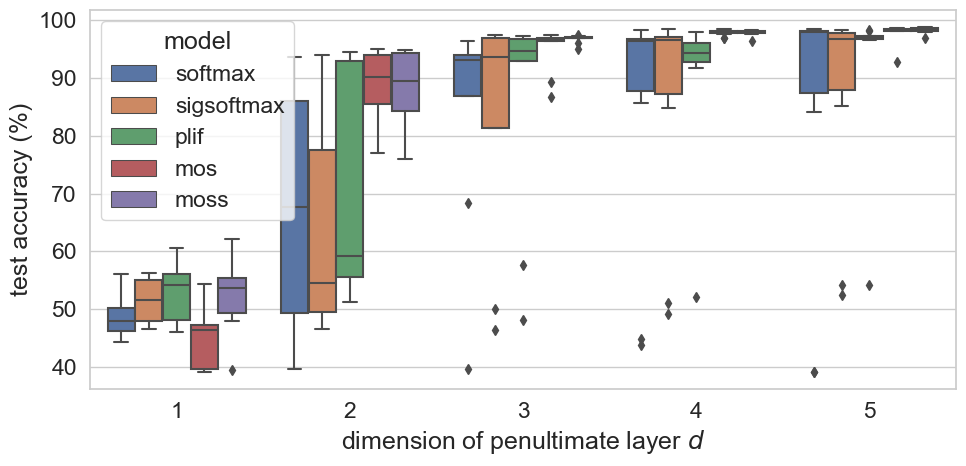

In [11]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=only_lucky_df[only_lucky_df['d'] < 6],
            x="d", y="accuracy", hue="model", ax=ax,
            hue_order=PLOT_ORDER)
sns.set(font_scale=1.5)
ax.set(xlabel='dimension of penultimate layer $d$', ylabel='test accuracy (%)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/mnist_accuracy_low_d.pdf')

## Boxplots on iNaturalist

In [12]:
scores = build_scores_dict("inat")

In [13]:
ds = scores['softmax'].keys()
activations = scores.keys()
accuracy_df = pd.DataFrame(columns=['model', 'd', 'accuracy'])
for activation in activations:
    for d in ds:
        for accuracy in scores[activation][d]['test_accuracy']:
            accuracy_df = accuracy_df.append(
                {'d': d, 'model': activation,
                 'accuracy': accuracy}, ignore_index=True)
accuracy_df.head()

,model,d,accuracy
0,sigsoftmax,1,3.4
1,sigsoftmax,1,3.7
2,sigsoftmax,1,3.8
3,sigsoftmax,1,3.9
4,sigsoftmax,1,3.4


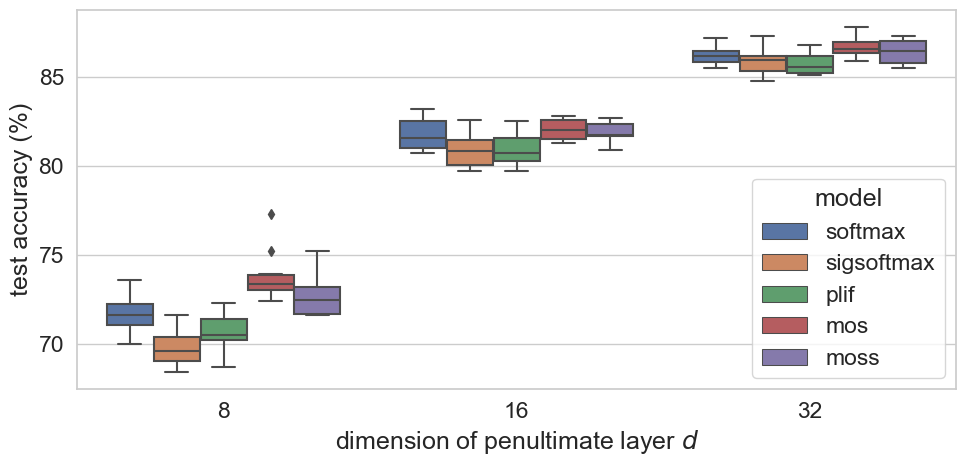

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=accuracy_df[accuracy_df['d']>6],
            x="d", y="accuracy", hue="model", ax=ax,
            hue_order=PLOT_ORDER)
sns.set(font_scale=1.5)
ax.set(xlabel='dimension of penultimate layer $d$', ylabel='test accuracy (%)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/inat_accuracy_high_d.pdf')

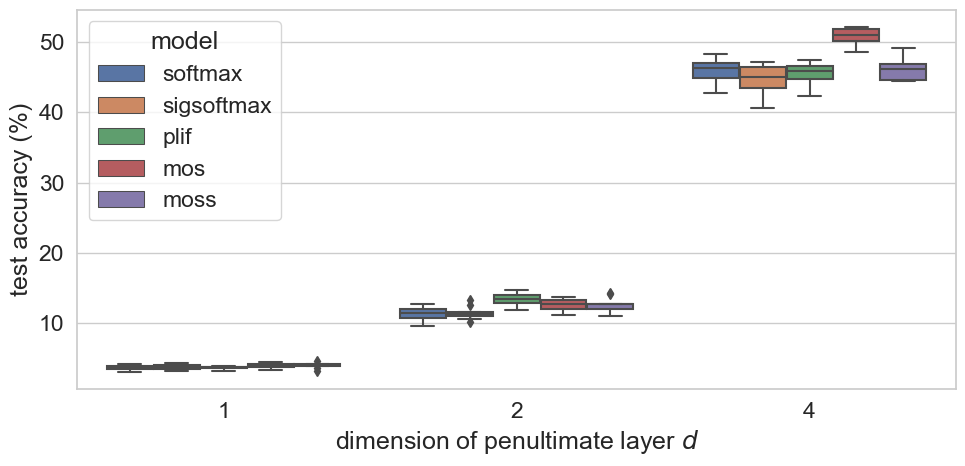

In [15]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=accuracy_df[accuracy_df['d']<6],
            x="d", y="accuracy", hue="model", ax=ax,
            hue_order=PLOT_ORDER)
sns.set(font_scale=1.5)
ax.set(xlabel='dimension of penultimate layer $d$', ylabel='test accuracy (%)')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/inat_accuracy_low_d.pdf')

## Impact of mixtures on iNaturalist

In [16]:
# M replaces d
scores = build_scores_dict("mixtures")

In [17]:
df = pd.DataFrame(columns=['m', 'test_accuracy'])
for m in list(range(1,10)) + list(range(10, 210, 10)):
    for test_accuracy in scores['mos'][m]['test_accuracy']:
        df = df.append({'m': m, 'test_accuracy': test_accuracy},
                        ignore_index=True)
df['m'] = df['m'].astype(int)
df.head()

,m,test_accuracy
0,1,45.8
1,1,44.8
2,1,44.5
3,1,45.9
4,1,47.5


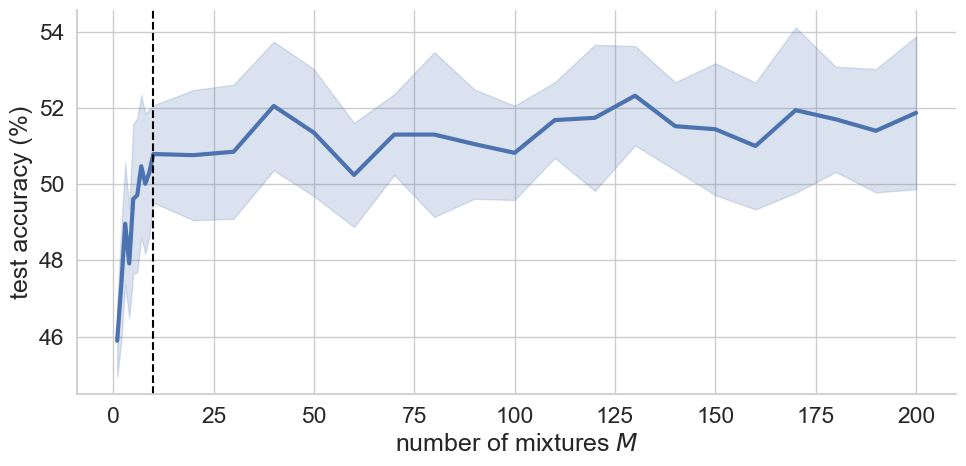

In [18]:
sns.set_style("whitegrid")
ax = sns.relplot(
    data=df, kind="line", linewidth = 3,
    x="m", y="test_accuracy", errorbar="sd",
)
ax.fig.set_size_inches(10, 5)
ax.set(xlabel='number of mixtures $M$', ylabel='test accuracy (%)')
sns.set(font_scale=1.5)
plt.axvline(x = 10, color = 'black', ls='--')
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/num_mixtures.pdf')